In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mcerp import correlate, correlation_matrix, plotcorr
from mcerp import Beta, N, Exp, PERT
from mcerp import uv, stats
# from mcerp import *

from scipy import stats as stats
from scipy.stats import rv_continuous, beta, genextreme, rv_histogram
import scipy.optimize as opt


import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = '{:.3f}'.format

nR = 10000

# Simulation without correlations

In [2]:
# distribution parameters:
min, mode, max, lmb = 8000.0, 12000.0, 18000.0, 4.0         # sales volume, PERT estimae
ms, ss = 20.0, 1.0                                          # selling price, normally distributed
mm, sm = 13.0, 0.7                                          # material unit cost, normally distributed 
o = 3.0                                                     # other unit cost, deterministic    

In [3]:
# setting up the simulation model BEFORE calibrating correlations:

# input variables:
v1 = PERT(min, mode, max, lmb)                  # sales volume, PERT distributed
p1 = N(ms, ss)                                  # selling price, normally distributed
m1 = N(mm, sm)                                  # material unit cost, normally distributed 
o1 = o                                          # other unit cost, deterministic    


# output variables:
GP1 = v1 * (p1 - m1 - o1)                       # simulation output: Gross Profit
R1 = v1 * p1                                    # simulation output: Revenues
GM1 = GP1 / R1                                  # simulation output: Gross Margin
C1 = R1 - GP1                                   # simulation output: Total Cost


In [4]:
# run the simulation model, 
# and collect the results in array variables

# number of mcerp samples
npts = nR

# assign the 6x 10,000 values to 6 variables so we can process their arrays later
rv1 = v1._mcpts
rp1 = p1._mcpts
rm1 = m1._mcpts
rGP1 = GP1._mcpts
rR1 = R1._mcpts
rGM1 = GM1._mcpts

# combine the 6 arrays in a 2-dimensional array
rand1 = np.vstack((rv1, rp1, rm1, rGP1, rR1, rGM1))

# copy the array to a dataframe for a more transparent layout
df1 = pd.DataFrame(data=rand1).T 
df1.rename(columns={ 
    0:"volume 1", 1:"price 1", 2:"material 1", 3:"Gross Profit 1", 4:"Revenues 1", 5:"Gross Margin 1"}, 
    inplace=True)
df1


,volume 1,price 1,material 1,Gross Profit 1,Revenues 1,Gross Margin 1
0,11480.681,18.618,14.176,16564.357,213751.904,0.077
1,10343.172,20.693,13.809,40171.651,214028.650,0.188
2,14867.048,21.718,12.728,89055.138,322887.755,0.276
3,11163.539,21.186,13.432,53068.835,236506.013,0.224
4,12352.884,19.381,13.019,41533.493,239416.891,0.173
...,...,...,...,...,...,...
9995,12852.080,19.375,12.106,54862.810,249006.343,0.220
9996,11277.655,20.471,13.685,42694.195,230859.724,0.185
9997,12099.811,20.632,14.397,39146.857,249647.151,0.157
9998,11104.419,19.215,14.094,23558.099,213372.020,0.110


In [5]:
# helper function: plot histogram
def plot_hist(data, title):
    hist = np.histogram(data, bins=100)
    histdist = rv_histogram(hist)

    X = np.linspace(data.min(), data.max(), 100)
    plt.title(title)
    plt.hist(data, density=True, bins=100)
    plt.plot(X, histdist.pdf(X))
    plt.show()

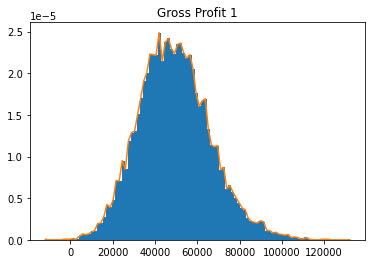

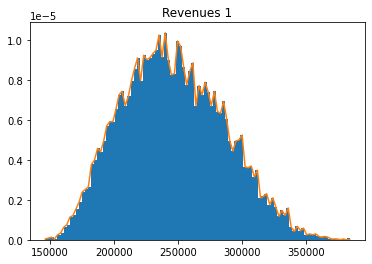

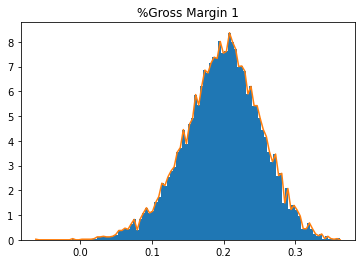

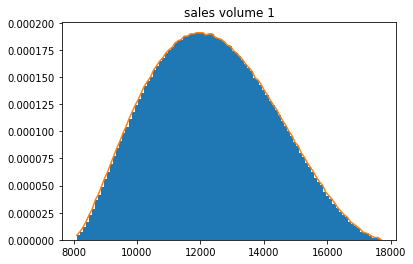

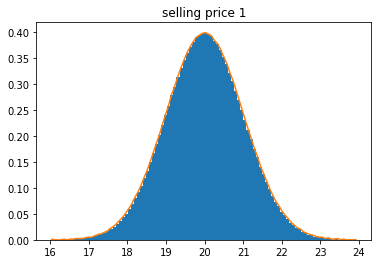

In [6]:
# results: draw histograms
plot_hist(rGP1, "Gross Profit 1")
plot_hist(rR1, "Revenues 1")
plot_hist(rGM1, "%Gross Margin 1")
plot_hist(rv1, "sales volume 1")
plot_hist(rp1, "selling price 1")


In [7]:
# distribution properties of the inputs: moments
def input_moments(v, p, m):
    # simulation inputs: moments
    print("sales volume:")
    v1.describe()
    print("selling price:")
    p1.describe()
    print("raw material unit cost:")
    m1.describe()

In [8]:
# simulation output: moments
def output_moments(GP, R, GM, C):
    print("Gross Profit:")
    GP1.describe()
    print("Revenues:")
    R1.describe()
    print("Gross Margin:")
    GM1.describe()
    print("Total Cost:")
    C1.describe()

In [9]:
# get the simulation results:
inmom1 = input_moments(v1, p1, m1)
inmom1


sales volume:
MCERP Uncertain Value:
 > Mean...................  12333.33083506654
 > Variance...............  3507888.890180063
 > Skewness Coefficient...  0.17793280021612795
 > Kurtosis Coefficient...  2.375420890626274

selling price:
MCERP Uncertain Value:
 > Mean...................  20.000001014447374
 > Variance...............  0.9998771951673667
 > Skewness Coefficient... -3.930118762284572e-05
 > Kurtosis Coefficient...  2.9966380254789406

raw material unit cost:
MCERP Uncertain Value:
 > Mean...................  12.999986855565242
 > Variance...............  0.48992093877336684
 > Skewness Coefficient... -0.0008522291598882486
 > Kurtosis Coefficient...  2.9953503019154404



In [10]:
# get the simulation results:
outmom1 = output_moments(GP1, R1, GM1, C1)
outmom1

Gross Profit:
MCERP Uncertain Value:
 > Mean...................  49351.35962662986
 > Variance...............  282772136.0366073
 > Skewness Coefficient...  0.3490907749404397
 > Kurtosis Coefficient...  3.289658736913242

Revenues:
MCERP Uncertain Value:
 > Mean...................  246672.57674020086
 > Variance...............  1561548099.1185029
 > Skewness Coefficient...  0.23931730924414857
 > Kurtosis Coefficient...  2.5663575425272014

Gross Margin:
MCERP Uncertain Value:
 > Mean...................  0.19804324058179187
 > Variance...............  0.0027738414401548253
 > Skewness Coefficient... -0.2301761891754654
 > Kurtosis Coefficient...  3.124013495942665

Total Cost:
MCERP Uncertain Value:
 > Mean...................  197321.21711357098
 > Variance...............  968666032.8639883
 > Skewness Coefficient...  0.21746779102470498
 > Kurtosis Coefficient...  2.5172970944001123



In [11]:
# get the correlation matrix BEFORE recalibrating
c1 = correlation_matrix([v1, p1, m1])
c1

array([[ 1.   ,  0.003, -0.009],
       [ 0.003,  1.   ,  0.033],
       [-0.009,  0.033,  1.   ]])

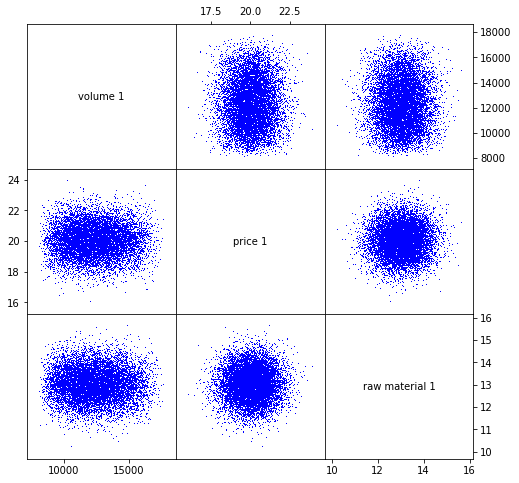

In [12]:
# plot correlations BEFORE recalibrating
corrplot0 = plotcorr([v1, p1, m1], labels=["volume 1", "price 1", "raw material 1"])

In [13]:
mean1 = GP1.mean
std1 = GP1.std
skew1 = GP1.skew
kurt1 = GP1.kurt
moments1 = [mean1, std1, skew1, kurt1]

# Impose different correlations

In [14]:
# targeted correlation matrix: volume, price, material unit cost
c_target = np.array(    [[  1.0, -0.3,  0.2],
                        [  -0.3,  1.0,  0.7],
                        [   0.2,  0.7,  1.0]])

In [15]:
v2 = PERT(min, mode, max, lmb)                  # sales volume, PERT distributed
p2 = N(ms, ss)                                  # selling price, normally distributed
m2 = N(mm, sm)                                  # material unit cost, normally distributed 
o2 = o                                          # other unit cost, deterministic    

In [16]:
# impose the targeted correlation matrix on the 3 input variables
correlate([v2, p2, m2], c_target)


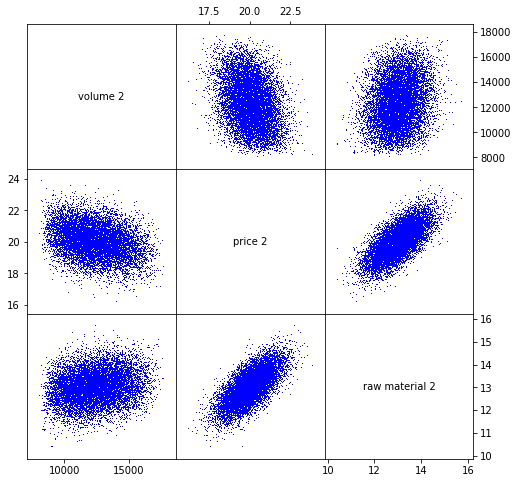

In [17]:
# plot the new correlation matrix of the input variables
corrplot2 = plotcorr([v2, p2, m2], labels=["volume 2", "price 2", "raw material 2"])

In [18]:
# check the new correlation matrix for the 3 input variables
c2 = correlation_matrix([v2, p2, m2])
c2

array([[ 1.   , -0.298,  0.199],
       [-0.298,  1.   ,  0.7  ],
       [ 0.199,  0.7  ,  1.   ]])

In [19]:
# deviations from targeted correlations?
c2 - c_target

array([[ 0.   ,  0.002, -0.001],
       [ 0.002,  0.   , -0.   ],
       [-0.001, -0.   ,  0.   ]])

In [20]:
# induced changes vs original correlations
c2 - c1

array([[ 0.   , -0.301,  0.208],
       [-0.301,  0.   ,  0.667],
       [ 0.208,  0.667,  0.   ]])

In [21]:
# output variables:
# we rename the output variables to use consistent variable names in simu1 and simu2
GP2 = v2 * (p2 - m2 - o2)                       # simulation output: Gross Profit
R2 = v2 * p2                                    # simulation output: Revenues
GM2 = GP2 / R2                                  # simulation output: Gross Margin
C2 = R2 - GP2                                   # simulation output: Total Cost

In [22]:
# assign the 6x 10,000 variates to 6 variables so we can process their arrays later
rv2 = v2._mcpts
rp2 = p2._mcpts
rm2 = m2._mcpts
rGP2 = GP2._mcpts
rR2 = R2._mcpts
rGM2 = GM2._mcpts

# combine the 6 arrays in a 2-dimensional array
rand2 = np.vstack((rv2, rp2, rm2, rGP2, rR2, rGM2))

# copy the array to a dataframe for a more transparent layout
df2 = pd.DataFrame(data=rand2).T 
df2.rename(columns={ 
    0:"volume 2", 1:"price 2", 2:"material 2", 3:"Gross Profit 2", 4:"Revenues 2", 5:"Gross Margin 2"}, 
    inplace=True)
df2

,volume 2,price 2,material 2,Gross Profit 2,Revenues 2,Gross Margin 2
0,10932.733,20.184,13.037,45333.402,220666.874,0.205
1,12252.822,19.145,12.322,46847.984,234582.825,0.200
2,10144.324,21.611,13.337,53500.895,219225.321,0.244
3,12868.642,20.959,14.209,48246.636,269708.073,0.179
4,11538.153,19.537,13.183,38703.353,225426.486,0.172
...,...,...,...,...,...,...
9995,9807.729,21.279,13.383,48018.851,208702.273,0.230
9996,13465.271,21.248,13.797,59931.027,286107.010,0.209
9997,13329.834,19.300,12.828,46281.932,257264.951,0.180
9998,13084.746,18.102,12.267,37089.499,236860.287,0.157


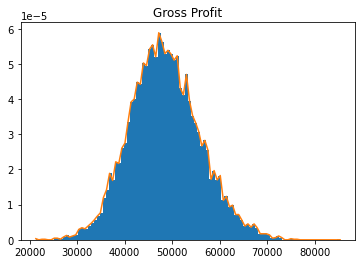

In [23]:
# results: draw histograms
plot_hist(rGP2, "Gross Profit")


In [24]:
# compare the main moments of the Gross Profit variable between the 2 simulation models:
moments_names = ["mean", "std", "skew", "kurt"]
moments2 = [GP2.mean, GP2.std, GP2.skew, GP2.kurt]

df = pd.DataFrame([moments1, moments2], columns=moments_names).T
df.rename(columns={0:"before", 1:"after"}, inplace=True)
df["variance"] = df["after"] - df["before"] 
df["%var"] = df["variance"] / df["before"] 
print("Moments of Gross Profit target variable: before vs after recalibrating correlations:")
df

Moments of Gross Profit target variable: before vs after recalibrating correlations:


,before,after,variance,%var
mean,49351.360,48514.645,-836.715,-0.017
std,16815.830,7371.603,-9444.226,-0.562
skew,0.349,0.206,-0.143,-0.410
kurt,3.290,3.160,-0.129,-0.039


In [25]:
    # quantiles of Gross Profit:
    q1 = np.array([0.001, 0.01, 0.99, 0.999])
    q2 = np.arange(0.05, 0.95, 0.05)
    q = np.concatenate((q1,q2))
    q.sort()
    xq = np.quantile(rGP2, q)
    
    qstr = [str(f'{v:.3f}') for v in q]
    dict_quantiles = dict(zip(qstr, xq))
    print("\nquantiles:")
    _ = [print(q,":",f'{xq:,.0f}') for q,xq in dict_quantiles.items()]


quantiles:
0.001 : 26,956
0.010 : 32,025
0.050 : 36,971
0.100 : 39,360
0.150 : 41,092
0.200 : 42,352
0.250 : 43,487
0.300 : 44,519
0.350 : 45,495
0.400 : 46,379
0.450 : 47,303
0.500 : 48,171
0.550 : 49,135
0.600 : 50,063
0.650 : 51,042
0.700 : 52,112
0.750 : 53,230
0.800 : 54,552
0.850 : 56,142
0.900 : 58,088
0.990 : 67,150
0.999 : 72,315
